In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

# 주식 가격 데이터 로드 (Upstart Holdings, Inc. 주식 가격 데이터 예시)
data = yf.download('UPST', start='2020-01-01', end='2023-09-06')

# 가격 열 선택 (종가 데이터 사용)
prices = data['Close'].values.astype(float)

[*********************100%%**********************]  1 of 1 completed


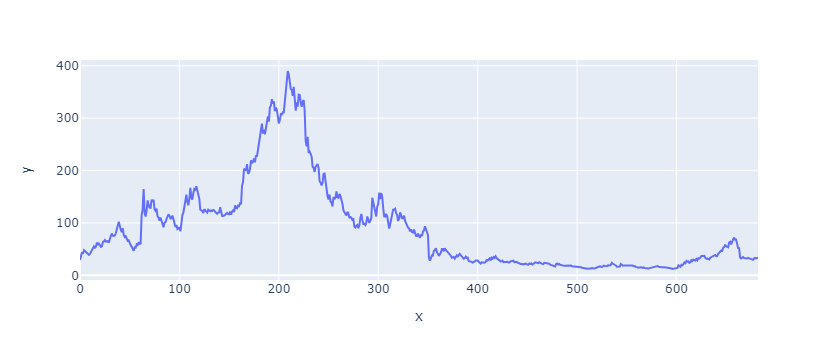

In [47]:
#plotly를 통한 시각화
import plotly.express as px
fi = px.line(x=np.arange(len(prices)),y=prices)
fi.show()

In [48]:
# 데이터를 시퀀스 형태로 변경
def make_batch(input_data, sl):
    train_x = []
    train_y = []
    L = len(input_data)
    for i in range(L-sl):
        train_seq = input_data[i:i+sl]
        train_label = input_data[i+sl:i+sl+1]
        train_x.append(train_seq)
        train_y.append(train_label)
    return train_x, train_y
sequence=5
data_x, data_y = make_batch(prices.reshape(-1,1), sequence)

In [49]:
class simple_lstm(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input_vector = 1
        self.output_vector = 100
        self.num_layers = 4
        
        self.lstm = nn.LSTM(input_size=self.input_vector, hidden_size=self.output_vector, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.output_vector, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
        
    def forward(self, x):
        output, _ = self.lstm(x) 
        return self.linear(output[:,-1,:])
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [75]:
point=int(len(data_x) * 0.8)
train_x=data_x[:point]
train_y=data_y[:point]
test_x=data_x[point:]
test_y=data_y[point:]
print(len(train_x))
print(len(test_x))    

542
136


In [76]:
tensor_x = torch.Tensor(train_x)
tensor_y = torch.Tensor(train_y)
dangjin_floating = simple_lstm()
dangjin_floating = dangjin_floating.to(device)
learning_rate = 0.0001 
optimizer = torch.optim.Adam(dangjin_floating.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
epochs=2000

for i in range(epochs):
    dangjin_floating.train()
    tensor_x = tensor_x.to(device)
    tensor_y = tensor_y.to(device)
    output = dangjin_floating(tensor_x)
    loss = criterion(output, tensor_y.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%100 == 0:
        print('Epoch {}, Loss {:.5f}'.format(i, loss.item()))

Epoch 0, Loss 18136.33594
Epoch 100, Loss 17367.03125
Epoch 200, Loss 13502.55371
Epoch 300, Loss 8758.94434
Epoch 400, Loss 6601.61475
Epoch 500, Loss 2378.76636
Epoch 600, Loss 819.80945
Epoch 700, Loss 292.13220
Epoch 800, Loss 153.55429
Epoch 900, Loss 112.39693
Epoch 1000, Loss 97.20363
Epoch 1100, Loss 89.14334
Epoch 1200, Loss 84.02416
Epoch 1300, Loss 80.49298
Epoch 1400, Loss 77.85970
Epoch 1500, Loss 75.74293
Epoch 1600, Loss 74.13297
Epoch 1700, Loss 72.25021
Epoch 1800, Loss 70.78281
Epoch 1900, Loss 69.52515


Test Loss: 8.51593


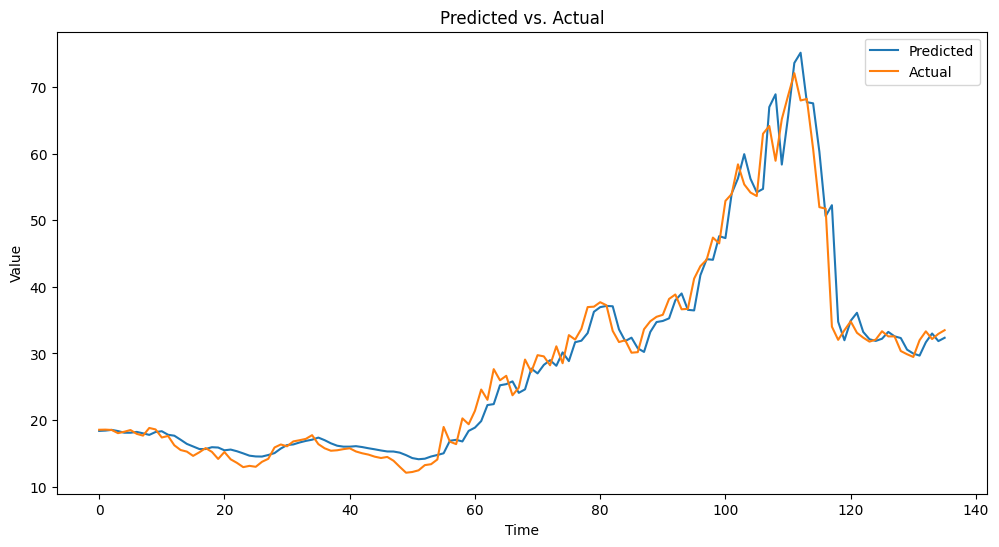

In [78]:
import matplotlib.pyplot as plt

# 테스트 데이터를 텐서로 변환
tensor_test_x = torch.Tensor(test_x)
tensor_test_y = torch.Tensor(test_y)

# 모델의 평가 모드로 전환
dangjin_floating.eval()
with torch.no_grad():
    tensor_test_x = tensor_test_x.to(device)
    tensor_test_y = tensor_test_y.to(device)
    test_output = dangjin_floating(tensor_test_x)

# 예측 결과와실제 값 간의 비교 및 시각화
test_loss = criterion(test_output, tensor_test_y.view(-1, 1)).item()
print('Test Loss: {:.5f}'.format(test_loss))

predicted_values = test_output.view(-1).cpu().numpy()
actual_values = tensor_test_y.view(-1).cpu().numpy()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(predicted_values, label='Predicted')
plt.plot(actual_values, label='Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. Actual')
plt.show()